In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random

import numpy as np
import torch
import matplotlib.pyplot as plt
opj = os.path.join
import pickle as pkl

from ex_biology import p

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# adaptive-wavelets modules
import awd
from awd.mdata.biology import get_dataloader, load_pretrained_model
from awd.utils import get_wavefun, get_1dfilts
from awd.visualize import plot_1dfilts, plot_wavefun

# init fit

In [2]:
p.wave = 'coif2'
p.J = 4
p.mode = 'zero'
p.init_factor = 1
p.noise_factor = 0
p.const_factor = 0
p.num_epochs = 100
p.attr_methods = 'Saliency'

lamWaveloss = 1
p.lamlSum = lamWaveloss
p.lamhSum = lamWaveloss
p.lamL2sum = lamWaveloss
p.lamCMF = lamWaveloss
p.lamConv = lamWaveloss
p.lamL1wave = 0.01
p.lamL1attr = 0.0
p.target = 0

In [3]:
# load data and model
train_loader, test_loader = get_dataloader(p.data_path,
                                           batch_size=p.batch_size,
                                           is_continuous=p.is_continuous)

model = load_pretrained_model(p.model_path, device=device)

# prepare model
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

wt = awd.DWT1d(wave=p.wave, mode=p.mode, J=p.J,
               init_factor=p.init_factor,
               noise_factor=p.noise_factor,
               const_factor=p.const_factor).to(device)
wt.train()

# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=p.lr)
loss_f = awd.get_loss_f(lamlSum=p.lamlSum, lamhSum=p.lamhSum, lamL2norm=p.lamL2norm, lamCMF=p.lamCMF,
                        lamConv=p.lamConv, lamL1wave=p.lamL1wave, lamL1attr=p.lamL1attr)
trainer = awd.Trainer(model, wt, optimizer, loss_f, target=p.target,
                      use_residuals=True, attr_methods=p.attr_methods, device=device, n_print=5)

In [4]:
# run
trainer(train_loader, epochs=p.num_epochs)

Starting Training Loop...
Train Epoch: 0 [1044/2936 (97%)]	Loss: 0.044454
====> Epoch: 0 Average train loss: 0.0494
Train Epoch: 5 [1044/2936 (97%)]	Loss: 0.039843
====> Epoch: 5 Average train loss: 0.0443
Train Epoch: 10 [1044/2936 (97%)]	Loss: 0.051937
====> Epoch: 10 Average train loss: 0.0445
Train Epoch: 15 [1044/2936 (97%)]	Loss: 0.040974
====> Epoch: 15 Average train loss: 0.0442
Train Epoch: 20 [1044/2936 (97%)]	Loss: 0.045932
====> Epoch: 20 Average train loss: 0.0443
Train Epoch: 25 [1044/2936 (97%)]	Loss: 0.047290
====> Epoch: 25 Average train loss: 0.0443
Train Epoch: 30 [1044/2936 (97%)]	Loss: 0.040873
====> Epoch: 30 Average train loss: 0.0441
Train Epoch: 35 [1044/2936 (97%)]	Loss: 0.047012
====> Epoch: 35 Average train loss: 0.0442
Train Epoch: 40 [1044/2936 (97%)]	Loss: 0.042061
====> Epoch: 40 Average train loss: 0.0440
Train Epoch: 45 [1044/2936 (97%)]	Loss: 0.042565
====> Epoch: 45 Average train loss: 0.0441
Train Epoch: 50 [1044/2936 (97%)]	Loss: 0.044483
====> Epo

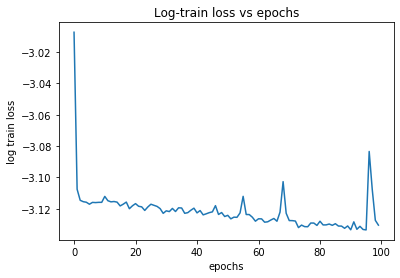

In [5]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [6]:
print('calculating losses and metric...')
model.train()  # cudnn RNN backward can only be called in training mode
validator = awd.Validator(model, test_loader)
rec_loss, lsum_loss, hsum_loss, L2norm_loss, CMF_loss, conv_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(
    wt, target=p.target)
print("Recon={:.5f}\n lsum={:.5f}\n hsum={:.5f}\n L2norm={:.5f}\n CMF={:.5f}\n conv={:.5f}\n L1wave={:.5f}\n Saliency={:.5f}\n Inputxgrad={:.5f}\n".format(rec_loss,
                                      lsum_loss,
                                      hsum_loss,
                                      L2norm_loss,
                                      CMF_loss,
                                      conv_loss,
                                      L1wave_loss,
                                      L1saliency_loss,
                                      L1inputxgrad_loss))


calculating losses and metric...
Recon=0.00000
 lsum=0.00000
 hsum=0.00000
 L2norm=0.00000
 CMF=0.00000
 conv=0.00000
 L1wave=4.27200
 Saliency=0.37390
 Inputxgrad=0.28642



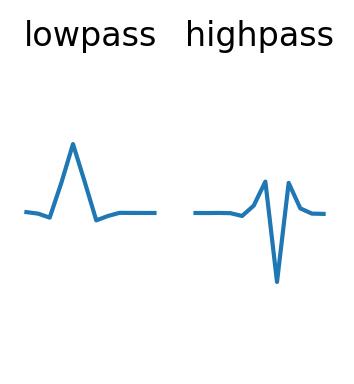

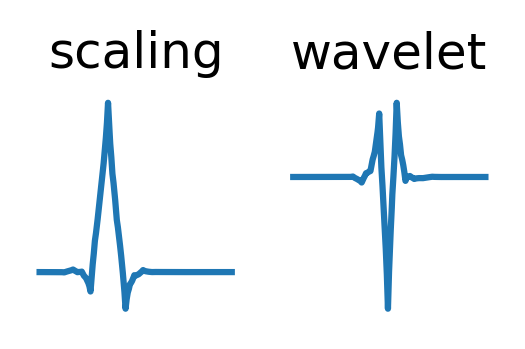

In [7]:
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(2,1))

# later fit

In [14]:
p.lamL1wave = 0.0001
p.lamL1attr = 2.0
p.num_epochs = 100

In [15]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=p.lr)
loss_f = awd.get_loss_f(lamlSum=p.lamlSum, lamhSum=p.lamhSum, lamL2norm=p.lamL2norm, lamCMF=p.lamCMF,
                        lamConv=p.lamConv, lamL1wave=p.lamL1wave, lamL1attr=p.lamL1attr)
trainer = awd.Trainer(model, wt, optimizer, loss_f, target=p.target,
                      use_residuals=True, attr_methods=p.attr_methods, device=device, n_print=5)

In [16]:
# run
trainer(train_loader, epochs=p.num_epochs)

Starting Training Loop...
Train Epoch: 0 [1044/2936 (97%)]	Loss: 0.901990
====> Epoch: 0 Average train loss: 0.7627
Train Epoch: 5 [1044/2936 (97%)]	Loss: 0.720028
====> Epoch: 5 Average train loss: 0.7539
Train Epoch: 10 [1044/2936 (97%)]	Loss: 0.834074
====> Epoch: 10 Average train loss: 0.7563
Train Epoch: 15 [1044/2936 (97%)]	Loss: 0.770845
====> Epoch: 15 Average train loss: 0.7533
Train Epoch: 20 [1044/2936 (97%)]	Loss: 0.742599
====> Epoch: 20 Average train loss: 0.7553
Train Epoch: 25 [1044/2936 (97%)]	Loss: 0.742735
====> Epoch: 25 Average train loss: 0.7540
Train Epoch: 30 [1044/2936 (97%)]	Loss: 0.694868
====> Epoch: 30 Average train loss: 0.7543
Train Epoch: 35 [1044/2936 (97%)]	Loss: 0.795443
====> Epoch: 35 Average train loss: 0.7540
Train Epoch: 40 [1044/2936 (97%)]	Loss: 0.778785
====> Epoch: 40 Average train loss: 0.7554
Train Epoch: 45 [1044/2936 (97%)]	Loss: 0.705887
====> Epoch: 45 Average train loss: 0.7533
Train Epoch: 50 [1044/2936 (97%)]	Loss: 0.789478
====> Epo

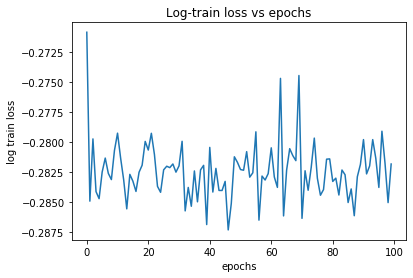

In [17]:
plt.plot(np.log(trainer.train_losses))
plt.xlabel("epochs")
plt.ylabel("log train loss")
plt.title('Log-train loss vs epochs')
plt.show()

In [18]:
print('calculating losses and metric...')
model.train()  # cudnn RNN backward can only be called in training mode
validator = awd.Validator(model, test_loader)
rec_loss, lsum_loss, hsum_loss, L2norm_loss, CMF_loss, conv_loss, L1wave_loss, L1saliency_loss, L1inputxgrad_loss = validator(
    wt, target=p.target)
print("Recon={:.5f}\n lsum={:.5f}\n hsum={:.5f}\n L2norm={:.5f}\n CMF={:.5f}\n conv={:.5f}\n L1wave={:.5f}\n Saliency={:.5f}\n Inputxgrad={:.5f}\n".format(rec_loss,
                                      lsum_loss,
                                      hsum_loss,
                                      L2norm_loss,
                                      CMF_loss,
                                      conv_loss,
                                      L1wave_loss,
                                      L1saliency_loss,
                                      L1inputxgrad_loss))


calculating losses and metric...
Recon=0.00132
 lsum=0.00000
 hsum=0.00033
 L2norm=0.00001
 CMF=0.00024
 conv=0.00001
 L1wave=4.29012
 Saliency=0.36556
 Inputxgrad=0.28340



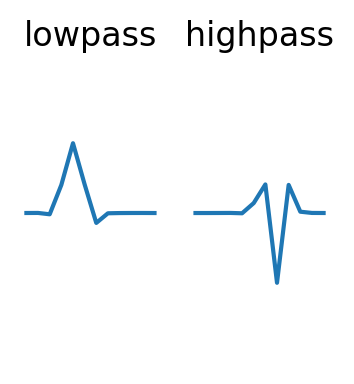

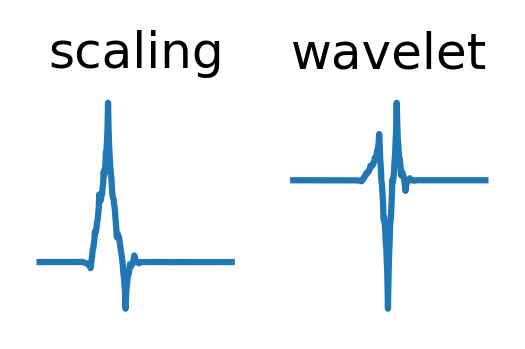

In [19]:
filt = get_1dfilts(wt)
phi, psi, x = get_wavefun(wt)

plot_1dfilts(filt, is_title=True, figsize=(2,2))
plot_wavefun((phi, psi, x), is_title=True, figsize=(2,1))